<a href="https://colab.research.google.com/github/MahithShetty/YelpFakeReviewDetection/blob/main/Final_Model_Fake_Review_Detection_on_Yelp_Restaurant_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset

Importing data set from google drive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/open?id=1LXx1PmNFrQzrxxlC5IkcLIUiNf-xEGge'
fluff, id = link.split('=')

In [ ]:
import pandas as pd
import numpy as np

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('yelp_restaurants_500k.csv')  
data = pd.read_csv('yelp_restaurants_500k.csv', header=0, sep=',', quotechar='"')

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.locked_file'

During handling of the above exception, another exceptio

# Data Pre-processing

In [ ]:
data['reviewContent'] = data.reviewContent.astype(str)
textData = pd.DataFrame(list(data['reviewContent']))
textData.head()

,0
0,The food is amazing. I have two tickets for t...
1,I did not know what to expect from this restau...
2,I liked the services offered by (Alinea) resta...
3,I liked the services offered by (Alinea) resta...
4,Presumably one of the best restaurants in Amer...


Making a customized list of stop words

In [ ]:
import nltk
import re
import string
from string import ascii_lowercase

from nltk import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

stopwords.extend([ 'place', 'room', 'im','ive','cant', 'youre', 'may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within','hotel','stay']+list(ascii_lowercase))
stoplist = [wn.lemmatize(stopword) for stopword in stopwords]
stoplist = set(stoplist)
stopList2 = [''.join(x for x in s if x not in string.punctuation) for s in stopwords]
stopWords = set(sorted(stopwords + list(stoplist) + stopList2))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Cleaning Text
- Remove punctions
- Remove digits
- Split sentences on whitespace 
- Remove stopwords

In [ ]:
def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub("\d+", "", text)
    tokens = re.split('\W+', text)
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopWords and wn.lemmatize(word) not in stopWords])
    return text
data['data_lemmatized'] = data['reviewContent'].apply(lambda x: clean_text(x.lower()))

data['data_lemmatized']

0         food amazing ticket tomorrow night sunday anyo...
1         know expect restaurant heard restaurant look l...
2         liked service offered alinea restaurant defini...
3         liked service offered alinea restaurant defini...
4         presumably best restaurant america prepared bl...
                                ...                        
499995    favorite north end restaurant came month ago l...
499996    great food great beer black bean maduro plaint...
499997    interesting store many cool specimen staff kno...
499998    love perfect drink go chris working fabulous b...
499999    bundled best winter coat braved icy cold weath...
Name: data_lemmatized, Length: 500000, dtype: object

In [ ]:
# cleaning the date string
data['date'] = data['date'].str.replace(r'[^0-9/]+', '')

Adding custom features

In [ ]:
# We will be using only 150 words for learning for each review
def trim_data_lem(text):
  text = word_tokenize(text)
  temp = " ".join(x for x in text[:148])
  return temp
data['trim_data_lemmatized'] = data['data_lemmatized'].apply(lambda x : trim_data_lem(x))
maxReviewLength = 155

In [ ]:
# adding all the features and other parameters
data['final_data_lemmatized'] = data['trim_data_lemmatized'].astype(str) + " "+ data['restaurantID'].astype(str) + " " + data['reviewerID'].astype(str)+ " " + data['rating'].astype(str)+ " " + data['date'].astype(str) + " " + data['usefulCount'].astype(str)+ " " +data['coolCount'].astype(str) + " " + data['funnyCount'].astype(str) 

In [ ]:
data['reviewLength_after_lemmatize']= data['final_data_lemmatized'].apply(lambda x: len(x)-x.count(" "))
data.describe()

,Unnamed: 0,rating,usefulCount,coolCount,funnyCount,reviewLength_after_lemmatize
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,98523.282068,3.753800,1.472662,0.974176,0.817584,404.090258
std,67136.817261,1.129899,2.698756,2.212480,2.216016,236.987768
min,0.000000,1.000000,0.000000,0.000000,0.000000,56.000000
25%,38898.750000,3.000000,0.000000,0.000000,0.000000,218.000000
50%,91490.500000,4.000000,1.000000,0.000000,0.000000,342.000000
75%,153990.250000,5.000000,2.000000,1.000000,1.000000,543.000000
max,241696.000000,5.000000,208.000000,170.000000,191.000000,1156.000000


# Labeling

Y/YR - Filtered Reviews - 1 

N/NR - Non-Filtered Reviews - 0

In [ ]:
from keras.utils.np_utils import to_categorical

data['flagged'] = np.where(np.logical_or(data['flagged']=='NR' , data['flagged']=='N'), 0, 1)
data['flagged']

def specific_class(c):
    if c['flagged'] == 0:
        return "TRUTH"
    else:
        return "FAKE"
    
data['given_class'] = data.apply(specific_class, axis=1)
print(data['given_class'])

0          FAKE
1          FAKE
2          FAKE
3          FAKE
4          FAKE
          ...  
499995    TRUTH
499996    TRUTH
499997    TRUTH
499998    TRUTH
499999    TRUTH
Name: given_class, Length: 500000, dtype: object


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


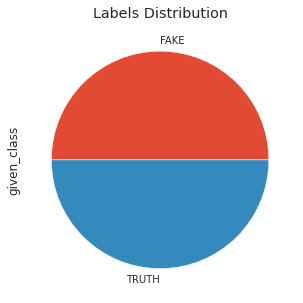

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('white')

label = data.given_class

pd.Series(label).value_counts().plot(kind='pie', title='Labels Distribution', figsize=(5, 5))

le = LabelEncoder()
le.fit(label)
dummy_y = le.transform(label)

# Train - Val - Test Split

Train 80% - Test 20% split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(data.final_data_lemmatized, 
                                                                        dummy_y, 
                                                               stratify=dummy_y,
                                                                  test_size=0.2, 
                                                                 random_state=3)
print("Train data= ",X_train.shape,"+",y_train.shape)  
print("Test data= ",X_test.shape,"+",y_test.shape)

Train data=  (400000,) + (400000,)
Test data=  (100000,) + (100000,)


Train 90% - Validation 10% split

In [ ]:
# X_train, X_val, y_train, y_val  = train_test_split(X_train, 
#                                                    y_train, 
#                                           stratify=y_train,
#                                              test_size=0.1, 
#                                             random_state=1)
# print("Train data= ",X_train.shape,"+",y_train.shape)  
# print("Val data= ",X_val.shape,"+",y_val.shape)

# Converting reviews to vectors

Converting texts to sequences and then applying padding

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
vocab_size = 400000
 
from keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer(num_words=vocab_size)
# word_tokenizer = Tokenizer()
 
word_tokenizer.fit_on_texts(X_train)
# vocab_size = len(word_tokenizer.word_index) + 1
print(vocab_size)
 
trainDatavecs = word_tokenizer.texts_to_sequences(X_train)
trainDataVecs = pad_sequences(trainDatavecs, maxlen=maxReviewLength, padding='post')
 
# valDataVecs = word_tokenizer.texts_to_sequences(X_val)
# valDataVecs = pad_sequences(valDataVecs, maxlen=maxReviewLength, padding='post')
 
testDataVecs = word_tokenizer.texts_to_sequences(X_test)
testDataVecs = pad_sequences(testDataVecs, maxlen=maxReviewLength, padding='post')

400000


# Training and Testing the Data

Deep Learning Model

In [ ]:
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dropout,  Bidirectional, Dense, BatchNormalization,  GlobalMaxPool1D, SpatialDropout1D
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.regularizers import l1_l2
import keras

model = Sequential()

model.add(Embedding(vocab_size, 256, input_length=maxReviewLength))

model.add((SpatialDropout1D(0.3)))

model.add(Conv1D(128, 5, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(0.5))

model.add(BatchNormalization())

model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))))
model.add(BatchNormalization())

model.add(Bidirectional(LSTM(32, dropout=0.25, recurrent_dropout=0.2, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))))
model.add(BatchNormalization())

model.add(GlobalMaxPool1D())

model.add(Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 155, 256)          102400000 
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 155, 256)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 151, 128)          163968    
_________________________________________________________________
dropout (Dropout)            (None, 151, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 128)           5

Training the data

In [ ]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 

final_accuracies = []
history_train = []

noOfEpochs = 10
batchSize = 1024 

# filename = 'best.weights.hdf5'
# checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
history_train.append(model.fit(trainDataVecs, y_train, epochs=noOfEpochs, batch_size=batchSize))
# model.load_weights(filename)
# predicted = np.rint(model.predict(valDataVecs))
# final_accuracies.append(accuracy_score(y_val, predicted))
# print(accuracy_score(y_val, predicted))

Epoch 1/10
  2/391 [..............................] - ETA: 13:04 - loss: 1.7615 - accuracy: 0.4941WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.9873s). Check your callbacks.


391/391 [==============================] - 334s 854ms/step - loss: 0.9303 - accuracy: 0.5250
Epoch 2/10
391/391 [==============================] - 329s 842ms/step - loss: 0.8536 - accuracy: 0.6038
Epoch 3/10
391/391 [==============================] - 327s 836ms/step - loss: 0.7567 - accuracy: 0.7057
Epoch 4/10
391/391 [==============================] - 329s 842ms/step - loss: 0.6355 - accuracy: 0.7917
Epoch 5/10
391/391 [==============================] - 329s 842ms/step - loss: 0.5432 - accuracy: 0.8426
Epoch 6/10
391/391 [==============================] - 325s 832ms/step - loss: 0.4737 - accuracy: 0.8755
Epoch 7/10
391/391 [==============================] - 326s 835ms/step - loss: 0.4231 - accuracy: 0.8955
Epoch 8/10
391/391 [==============================] - 326s 833ms/step - loss: 0.3855 - accuracy: 0.9088
Epoch 9/10
391/391 [==============================] - 325s 831ms/step - loss: 0.3544 - accuracy: 0.9185
Epoch 10/10
391/391 [==============================] - 327s 837ms/step - lo

Training Results

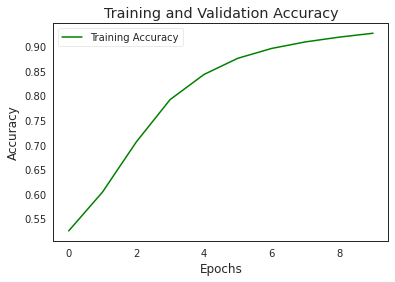

In [ ]:
from itertools import chain
import matplotlib.pyplot as plt

acc_train = history_train[0].history['accuracy']
# acc_val = history_train[0].history['val_accuracy']
epochs = range(0,len(acc_train))
plt.plot(epochs, acc_train, 'g', label='Training Accuracy')
# plt.plot(epochs, acc_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

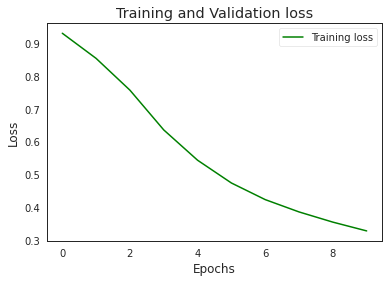

In [ ]:
loss_train = history_train[0].history['loss']
# loss_val = history_train[0].history['val_loss']
epochs = range(0,len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
# plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# print("Validation Accuracy = ", sum(final_accuracies) / len(final_accuracies))

Final Test Accuracy

In [ ]:
# model.load_weights(filename)
predicted = np.rint(model.predict(testDataVecs))
print("Test accuracy = ",accuracy_score(y_test, predicted))

Test accuracy =  0.85108
